# Predict an artist

Data set: https://www.kaggle.com/ikarus777/best-artworks-of-all-time

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import json
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from skimage.transform import resize
from collections import defaultdict
import random
import time
import warnings
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
import os
import shutil
import pandas as pd
import copy
from tqdm import tqdm

warnings.filterwarnings('ignore')

# Dataset

In [ ]:
os.chdir('/content/drive/MyDrive/education/images/images')

Train test split. Make it once

In [ ]:
"""root_dir = '/content/drive/MyDrive/education/images/images/' # data root path
classes_dir = [name for name in os.listdir(".")] #total labels

val_ratio = 0.15
test_ratio = 0.05

for cls in classes_dir:
    os.makedirs(root_dir +'train/' + cls)
    os.makedirs(root_dir +'val/' + cls)
    os.makedirs(root_dir +'test/' + cls)


# Creating partitions of the data after shuffeling
for cls in classes_dir:
    src = root_dir + cls # Folder to copy images from

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                            [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), 
                                                            int(len(allFileNames)* (1 - test_ratio))])


    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    # Copy-pasting images
    for name in train_FileNames:
            shutil.copy(name, root_dir +'train/' + cls)

    for name in val_FileNames:
            shutil.copy(name, root_dir +'val/' + cls)

    for name in test_FileNames:
            shutil.copy(name, root_dir +'test/' + cls)"""

'root_dir = \'/content/drive/MyDrive/education/images/images/\' # data root path\nclasses_dir = [name for name in os.listdir(".")] #total labels\n\nval_ratio = 0.15\ntest_ratio = 0.05\n\nfor cls in classes_dir:\n    os.makedirs(root_dir +\'train/\' + cls)\n    os.makedirs(root_dir +\'val/\' + cls)\n    os.makedirs(root_dir +\'test/\' + cls)\n\n\n# Creating partitions of the data after shuffeling\nfor cls in classes_dir:\n    src = root_dir + cls # Folder to copy images from\n\n    allFileNames = os.listdir(src)\n    np.random.shuffle(allFileNames)\n    train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),\n                                                            [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), \n                                                            int(len(allFileNames)* (1 - test_ratio))])\n\n\n    train_FileNames = [src+\'/\'+ name for name in train_FileNames.tolist()]\n    val_FileNames = [src+\'/\' + name for name in val

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
for_resize = (128, 128)
BATCH = 64

data_transforms = {
    'train': transforms.Compose([
            # transforms.ColorJitter(brightness=.5, hue=.3),
            # transforms.RandomEqualize(),
            transforms.RandomHorizontalFlip(),
            transforms.Resize(for_resize),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
            # transforms.ColorJitter(brightness=.5, hue=.3),
            # transforms.RandomEqualize(),
            transforms.RandomHorizontalFlip(),
            transforms.Resize(for_resize),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
    ]),
}

data_dir = '/content/drive/MyDrive/education/images/images'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH,
                                              shuffle=True, num_workers=8)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_classes = len(class_names)
print("Number of classes = ", num_classes)
print("Dataset size", dataset_sizes)
print("Device:", device)

Number of classes =  49
Dataset size {'train': 6481, 'val': 1216}
Device: cuda:0


In [ ]:
def im_convert(tensor):
    inv_normalize = transforms.Normalize(
        mean=[-m / s for m, s in zip(mean, std)],
        std=[1 / s for s in std])
    inv_tensor = inv_normalize(tensor)
    image = inv_tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    return image


def im_print(dataloader, class_name, dataset_size):
    plt.figure(figsize=(12, 6))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        image, label = dataloader.dataset.__getitem__(np.random.choice(dataset_size))
        plt.imshow(im_convert(image))
        plt.title(" ".join(class_name[label].split('_')), color='black')
        plt.axis('off')
    plt.show();

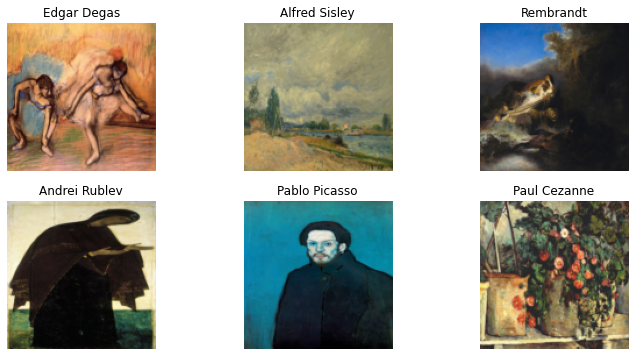

In [ ]:
im_print(dataloaders['train'], class_names, 6481)

# Model training

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    total_time = 0

    for epoch in range(num_epochs):
        since = time.time()
        print()
        print(f'Epoch {epoch}')

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
        time_elapsed = time.time() - since
        total_time += time_elapsed
        print(f"Epoch completed in {time_elapsed // 60} m {time_elapsed % 60:.2f} sec")

        print()
    print(f"Training finished in {total_time // 3600} h {total_time // 60} m {total_time % 60:.2f} sec")
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Classes balancing (number of pictures is slightly differ from class to class). Use it for model_ft.fc = nn.Linear(num_ftrs, num_classes)


In [ ]:
"""stat_train = dict()
for inputs, labels in tqdm(image_datasets['train']):
    if labels not in stat_train:
        stat_train[labels] = 0
    stat_train[labels] += 1

weights = torch.tensor(np.fromiter(stat_train.values(), dtype=float) / dataset_sizes['train'], dtype=torch.float,
                       device='cuda')"""

"stat_train = dict()\nfor inputs, labels in tqdm(image_datasets['train']):\n    if labels not in stat_train:\n        stat_train[labels] = 0\n    stat_train[labels] += 1\n\nweights = torch.tensor(np.fromiter(stat_train.values(), dtype=float) / dataset_sizes['train'], dtype=torch.float,\n                       device='cuda')"

In [ ]:
model_ft = models.resnext50_32x4d(pretrained=True, progress=True)  # resnext50_32x4d
num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, num_classes)
model_ft.fc = nn.Sequential(nn.Linear(2048, num_ftrs),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(num_ftrs, num_classes),
                                 nn.LogSoftmax(dim=1))

model_ft = model_ft.to(device)

# criterion = nn.CrossEntropyLoss(weight=weights)
criterion = nn.NLLLoss()
# criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)


Epoch 0
train Loss: 2.7692 Acc: 0.2972
val Loss: 2.8196 Acc: 0.2993
Epoch completed in 5.0 m 3.17 sec


Epoch 1
train Loss: 2.1438 Acc: 0.4208
val Loss: 2.2784 Acc: 0.4087
Epoch completed in 2.0 m 59.28 sec


Epoch 2
train Loss: 1.8542 Acc: 0.4896
val Loss: 2.1844 Acc: 0.4120
Epoch completed in 2.0 m 56.39 sec


Epoch 3
train Loss: 1.6199 Acc: 0.5459
val Loss: 1.8753 Acc: 0.4959
Epoch completed in 2.0 m 54.87 sec


Epoch 4
train Loss: 1.4071 Acc: 0.6059
val Loss: 2.0435 Acc: 0.4918
Epoch completed in 2.0 m 53.50 sec


Epoch 5
train Loss: 1.2920 Acc: 0.6303
val Loss: 1.9800 Acc: 0.5123
Epoch completed in 2.0 m 56.17 sec


Epoch 6
train Loss: 1.1425 Acc: 0.6720
val Loss: 1.8626 Acc: 0.5181
Epoch completed in 2.0 m 51.34 sec


Epoch 7
train Loss: 1.0230 Acc: 0.7082
val Loss: 1.9907 Acc: 0.5395
Epoch completed in 2.0 m 54.29 sec


Epoch 8
train Loss: 0.8925 Acc: 0.7365
val Loss: 2.0366 Acc: 0.5304
Epoch completed in 2.0 m 52.70 sec


Epoch 9
train Loss: 0.7975 Acc: 0.7570
val Loss: 2.1395

In [ ]:
torch.save(model_ft.state_dict(), 'resnext50_32x4d_gpu_v2.pth')

load model

In [ ]:
 model_ft = models.resnext50_32x4d(pretrained=True, progress=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)
model_ft = model_ft.to(device)
model_ft.load_state_dict(torch.load('resnext50_32x4d_gpu.pth'))

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
def visualize_model(model, dataloader, phase='val', num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10, 10))
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):

            outputs = model(inputs.cuda())
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(2, num_images // 2, images_so_far)
                ax.axis('off')
                pred = " ".join(class_names[preds[j]].split('_'))
                if phase == 'val':
                    label = " ".join(class_names[labels[j]].split('_'))
                    ax.set_title(f'predicted: {pred}, \nactual: {label}',
                             color="black")
                else:
                    label = " ".join(test_class_names[labels[j]].split('_'))
                    ax.set_title(f'predicted: {pred} \nactual: {label}',
                             color="black")

                """Imshow for Tensor."""
                inp = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
                ax.imshow(inp)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

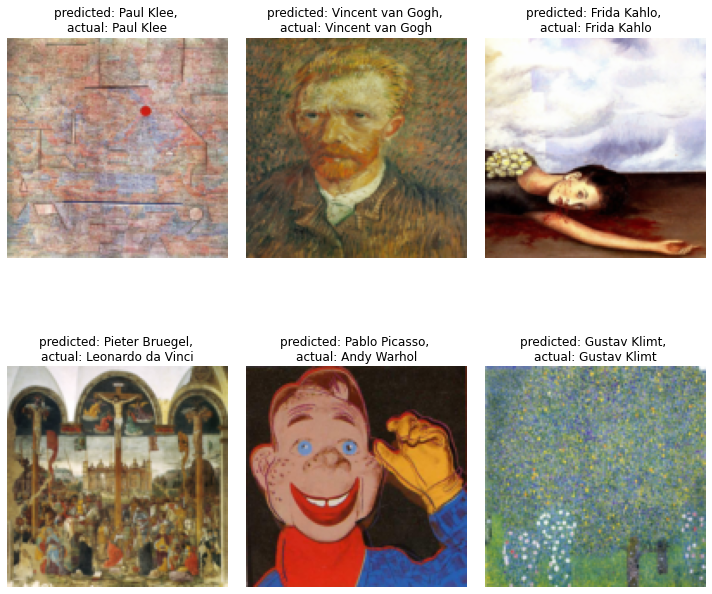

In [ ]:
visualize_model(model_ft, dataloaders['val'])
plt.tight_layout()
plt.show()

# Test model

Number of classes =  49
Dataset size 431


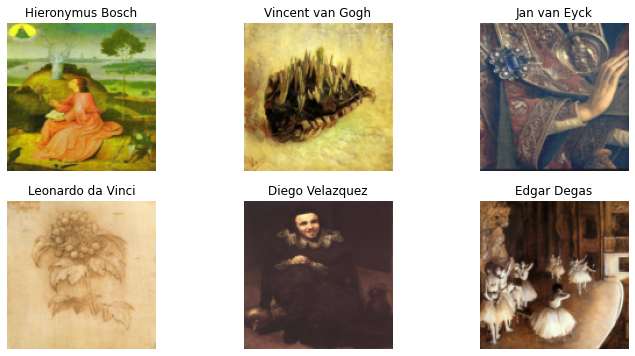

In [ ]:
test_path = "/content/drive/MyDrive/education/images/images/test/"

test_transform = transforms.Compose([
    transforms.Resize(for_resize),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_datasets = datasets.ImageFolder(test_path, test_transform)

testloader = torch.utils.data.DataLoader(test_datasets, batch_size=BATCH,
                                         shuffle=True, num_workers=8)

test_class_names = test_datasets.classes
test_num_classes = len(test_class_names)
print("Number of classes = ", test_num_classes)
print("Dataset size", len(test_datasets))

im_print(testloader, test_class_names, len(test_datasets))

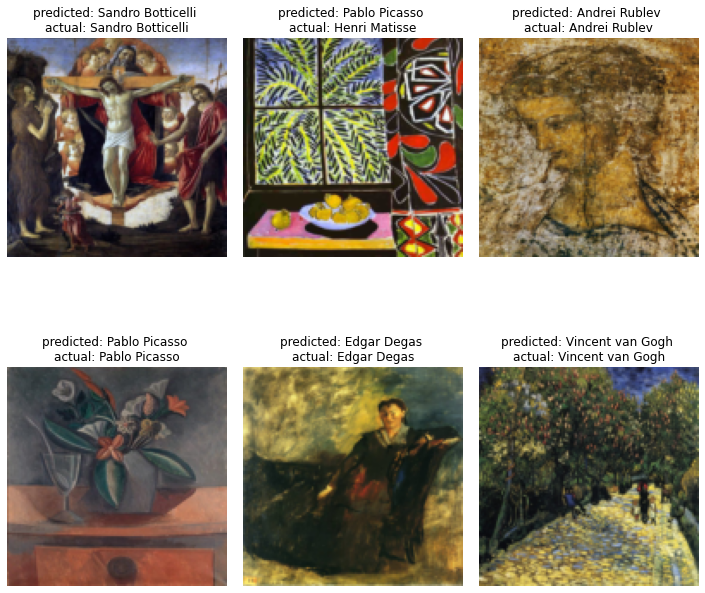

In [ ]:
visualize_model(model_ft, testloader, phase='test')
plt.tight_layout()
plt.show()